In [123]:
# import packages
import pandas as pd
import numpy as np
import scipy as scp
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib_venn as venn
from helper import *
import ipywidgets as widgets

# variables
time_period = (1, 2, 3, 4, 5) # 5 different implementation of progression order  
n_patients = 0 # number of patients included in the model  
n_sessions = 0 # number of sessions included in the model  
usage_time: how many months the patient has been using the app  
usage_freq: how frequent the patient uses the app  

Clean Data

In [91]:
# 1 min
df = pd.read_csv("data/context_action.csv")
df.drop(df.columns[[0, 1]], axis=1, inplace=True)
df.head()

,id,patient_id,task_type_id,task_level,completed_task_count,accuracy,domain_id,condition_since,birth_year,disorder_id,start_time,start_time_min,end_time,end_time_min,deficit_id
0,635715,15666,20,1,3,0.875,1,1y,1964,2,2014-07-31,2014-07-31 00:38:38,2014-07-31,2014-07-31 00:39:24,"{1, 2, 3, 4, 8}"
1,635715,15666,20,1,3,0.875,1,1y,1964,3,2014-07-31,2014-07-31 00:38:38,2014-07-31,2014-07-31 00:39:24,"{1, 2, 3, 4, 8}"
2,695385,15666,20,1,5,0.800,1,1y,1964,2,2014-08-18,2014-08-18 22:03:20,2014-08-18,2014-08-18 22:05:21,"{1, 2, 3, 4, 8}"
3,695385,15666,20,1,5,0.800,1,1y,1964,3,2014-08-18,2014-08-18 22:03:20,2014-08-18,2014-08-18 22:05:21,"{1, 2, 3, 4, 8}"
4,705234,15666,20,1,5,0.850,1,1y,1964,2,2014-08-21,2014-08-21 17:51:23,2014-08-21,2014-08-21 17:52:40,"{1, 2, 3, 4, 8}"


In [92]:
# 20 seconds
disorder_ids = df.groupby("patient_id")["disorder_id"].apply(set).reset_index()
df = df.drop(columns="disorder_id")
df = df.merge(disorder_ids, on="patient_id", how="left")

In [93]:
# 1 min
domain_ids = df.groupby("id")["domain_id"].apply(set).reset_index()
df = df.drop(columns="domain_id")
df = df.merge(domain_ids, on="id", how="left")

In [94]:
df = df.drop_duplicates(subset="id")

In [95]:
# df.to_csv("data/consolidate_data.csv")
## careful when reading, will read set as string
# df = pd.read_csv("data/consolidate_data.csv", index_col=[0])
df

,id,patient_id,task_type_id,task_level,completed_task_count,accuracy,condition_since,birth_year,start_time,start_time_min,end_time,end_time_min,deficit_id,disorder_id,domain_id
0,635715,15666,20,1,3,0.875,1y,1964,2014-07-31,2014-07-31 00:38:38,2014-07-31,2014-07-31 00:39:24,"{1, 2, 3, 4, 8}","{2, 3}",{1}
2,695385,15666,20,1,5,0.800,1y,1964,2014-08-18,2014-08-18 22:03:20,2014-08-18,2014-08-18 22:05:21,"{1, 2, 3, 4, 8}","{2, 3}",{1}
4,705234,15666,20,1,5,0.850,1y,1964,2014-08-21,2014-08-21 17:51:23,2014-08-21,2014-08-21 17:52:40,"{1, 2, 3, 4, 8}","{2, 3}",{1}
6,4929693,15666,20,1,5,0.800,1y,1964,2016-10-19,2016-10-19 20:47:01,2016-10-19,2016-10-19 20:48:29,"{1, 2, 3, 4, 8}","{2, 3}",{1}
32,5429562,15666,37,1,5,0.800,1y,1964,2016-12-13,2016-12-13 01:14:14,2016-12-13,2016-12-13 01:16:24,"{1, 2, 3, 4, 8}","{2, 3}","{1, 10, 11}"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61860683,14061511,217018,7,5,10,0.908,6m,1943,2018-11-05,2018-11-05 15:52:25,2018-11-05,2018-11-05 16:08:50,{3},"{3, 6}",{14}
61860685,14062555,217018,7,5,10,0.978,6m,1943,2018-11-05,2018-11-05 16:16:53,2018-11-05,2018-11-05 16:27:40,{3},"{3, 6}",{14}
61860687,14002360,217018,28,5,7,0.973,6m,1943,2018-11-01,2018-11-01 14:40:43,2018-11-01,2018-11-01 14:41:49,{3},"{3, 6}",{14}
61860707,19565141,324494,173,6,1,1.000,10y,1947,2019-08-26,2019-08-26 14:17:41,NaN,NaN,{6},{9},{14}


All data has been consolidated, there should be no duplicate sessions for different disorders/domains.
We want to add time_period, usage_time, and usage_freq to the dataset.

In [96]:
progression_order_df = pd.read_csv("data/progression_order.csv", index_col=[0])
progression_order_df.rename(columns={'time_implemented':'end_time'}, inplace=True)
progression_order_df["end_time"] = pd.to_datetime(progression_order_df["end_time"])
df["end_time"] = pd.to_datetime(df["end_time"])

In [37]:
def time_period_convert(dd):
    dates = sorted(pd.unique(progression_order_df["end_time"]))
    if dd < pd.to_datetime(dates[1]):
        return 1
    elif dd < pd.to_datetime(dates[2]):
        return 2
    elif dd < pd.to_datetime(dates[3]):
        return 3
    elif dd < pd.to_datetime(dates[4]):
        return 4
    else:
        return 5

In [97]:
# added time period, takes around 8-9 minutes to run
df["time_period"] = df["end_time"].apply(time_period_convert)
df

,id,patient_id,task_type_id,task_level,completed_task_count,accuracy,condition_since,birth_year,start_time,start_time_min,end_time,end_time_min,deficit_id,disorder_id,domain_id,time_period
0,635715,15666,20,1,3,0.875,1y,1964,2014-07-31,2014-07-31 00:38:38,2014-07-31,2014-07-31 00:39:24,"{1, 2, 3, 4, 8}","{2, 3}",{1},1
2,695385,15666,20,1,5,0.800,1y,1964,2014-08-18,2014-08-18 22:03:20,2014-08-18,2014-08-18 22:05:21,"{1, 2, 3, 4, 8}","{2, 3}",{1},1
4,705234,15666,20,1,5,0.850,1y,1964,2014-08-21,2014-08-21 17:51:23,2014-08-21,2014-08-21 17:52:40,"{1, 2, 3, 4, 8}","{2, 3}",{1},1
6,4929693,15666,20,1,5,0.800,1y,1964,2016-10-19,2016-10-19 20:47:01,2016-10-19,2016-10-19 20:48:29,"{1, 2, 3, 4, 8}","{2, 3}",{1},1
32,5429562,15666,37,1,5,0.800,1y,1964,2016-12-13,2016-12-13 01:14:14,2016-12-13,2016-12-13 01:16:24,"{1, 2, 3, 4, 8}","{2, 3}","{1, 10, 11}",1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61860683,14061511,217018,7,5,10,0.908,6m,1943,2018-11-05,2018-11-05 15:52:25,2018-11-05,2018-11-05 16:08:50,{3},"{3, 6}",{14},4
61860685,14062555,217018,7,5,10,0.978,6m,1943,2018-11-05,2018-11-05 16:16:53,2018-11-05,2018-11-05 16:27:40,{3},"{3, 6}",{14},4
61860687,14002360,217018,28,5,7,0.973,6m,1943,2018-11-01,2018-11-01 14:40:43,2018-11-01,2018-11-01 14:41:49,{3},"{3, 6}",{14},4
61860707,19565141,324494,173,6,1,1.000,10y,1947,2019-08-26,2019-08-26 14:17:41,NaT,NaN,{6},{9},{14},5


In [98]:
progression_order_df["time_period"] = progression_order_df["end_time"].apply(time_period_convert)
progression_order_df

,domain_id,root_id,task_type_id,task_level,progression_order,end_time,time_period
0,1,20,20,1,0,2012-01-01,1
1,1,20,20,2,1,2012-01-01,1
2,1,20,20,3,2,2012-01-01,1
3,1,20,20,4,3,2012-01-01,1
4,1,20,20,5,4,2012-01-01,1
...,...,...,...,...,...,...,...
1170,14,6,6,5,25,2019-10-08,5
1171,14,29,174,6,26,2019-10-08,5
1172,14,7,169,6,27,2019-10-08,5
1173,14,28,173,6,28,2019-10-08,5


Adding Usage Time
* this is by patient
* need a patient dataframe vs session dataframe (df)

In [99]:
patients = (df.groupby("patient_id")["end_time"].max() - df.groupby("patient_id")["end_time"].min()).reset_index()
patients.columns = ["patient_id", "usage_time"]
patients["usage_time"] = patients["usage_time"].dt.days + 1
patients

,patient_id,usage_time
0,14189,243.0
1,14561,666.0
2,14683,219.0
3,14685,495.0
4,14696,2180.0
...,...,...
97749,415551,14.0
97750,415603,16.0
97751,415758,3.0
97752,415867,22.0


Add usage_freq for patient dataframe
* using the simplest way of calculating frequency
* how to get rid of outlier

In [100]:
patients["session_count"] = df.groupby("patient_id")["id"].count().reset_index(name="session_count")["session_count"]
patients["unique_days"] = df.groupby("patient_id")["end_time"].nunique().reset_index(name="days")["days"]
patients

,patient_id,usage_time,session_count,unique_days
0,14189,243.0,292,40
1,14561,666.0,3,2
2,14683,219.0,513,26
3,14685,495.0,456,74
4,14696,2180.0,13988,1858
...,...,...,...,...
97749,415551,14.0,10,6
97750,415603,16.0,74,6
97751,415758,3.0,23,3
97752,415867,22.0,34,12


In [101]:
patients["usage_freq"] = patients["unique_days"] / patients["usage_time"]
patients

,patient_id,usage_time,session_count,unique_days,usage_freq
0,14189,243.0,292,40,0.164609
1,14561,666.0,3,2,0.003003
2,14683,219.0,513,26,0.118721
3,14685,495.0,456,74,0.149495
4,14696,2180.0,13988,1858,0.852294
...,...,...,...,...,...
97749,415551,14.0,10,6,0.428571
97750,415603,16.0,74,6,0.375000
97751,415758,3.0,23,3,1.000000
97752,415867,22.0,34,12,0.545455


How to remove outlier

In [102]:
# modified from https://stackoverflow.com/questions/56750841/how-to-trim-outliers-in-dates-in-python
def datetime_outlier(data):
    qa = data["end_time"].quantile(0.1) #lower 10%
    qb = data["end_time"] #higher 10%
    #remove outliers
    xf = data[(data.end_time >= qa) & (data.end_time <= qb)]
    return xf

In [103]:
# about a min
patients_v2 = df.groupby("patient_id").apply(datetime_outlier).reset_index(drop=True)

In [104]:
patients_v2

,id,patient_id,task_type_id,task_level,completed_task_count,accuracy,condition_since,birth_year,start_time,start_time_min,end_time,end_time_min,deficit_id,disorder_id,domain_id,time_period
0,585724,14189,20,2,5,0.940,5y,1970,2014-07-13,2014-07-13 16:53:02,2014-07-13,2014-07-13 16:54:18,"{2, 4}",{3},{1},1
1,588925,14189,20,2,5,0.960,5y,1970,2014-07-14,2014-07-14 21:57:40,2014-07-14,2014-07-14 21:58:54,"{2, 4}",{3},{1},1
2,771833,14189,20,3,5,0.584,5y,1970,2014-10-14,2014-10-14 22:04:59,2014-10-14,2014-10-14 22:10:10,"{2, 4}",{3},{1},1
3,891587,14189,20,3,2,0.000,5y,1970,2014-10-15,2014-10-15 18:42:43,2014-10-15,2014-10-15 18:42:47,"{2, 4}",{3},{1},1
4,899521,14189,20,3,2,0.000,5y,1970,2014-10-17,2014-10-17 21:34:25,2014-10-17,2014-10-17 21:34:36,"{2, 4}",{3},{1},1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6830779,25172712,416292,79,3,10,0.400,6m,1953,2020-06-28,2020-06-28 19:59:51,2020-06-28,2020-06-28 20:44:53,"{2, 3, 5, 6, 7, 8, 10}",{2},{9},5
6830780,25192411,416292,79,3,10,0.600,6m,1953,2020-06-30,2020-06-30 01:05:42,2020-06-30,2020-06-30 01:30:24,"{2, 3, 5, 6, 7, 8, 10}",{2},{9},5
6830781,25207353,416292,79,3,10,0.701,6m,1953,2020-06-30,2020-06-30 20:40:34,2020-06-30,2020-06-30 20:56:16,"{2, 3, 5, 6, 7, 8, 10}",{2},{9},5
6830782,25242119,416292,25,2,6,0.906,6m,1953,2020-07-02,2020-07-02 19:58:29,2020-07-02,2020-07-02 20:02:46,"{2, 3, 5, 6, 7, 8, 10}",{2},{12},5


In [105]:
patients_filtered = (patients_v2.groupby("patient_id")["end_time"].max() - patients_v2.groupby("patient_id")["end_time"].min()).reset_index()
patients_filtered.columns = ["patient_id", "usage_time"]
patients_filtered["usage_time"] = patients_filtered["usage_time"].dt.days + 1
patients_filtered

,patient_id,usage_time
0,14189,241
1,14561,666
2,14683,24
3,14685,493
4,14696,2032
...,...,...
95463,415551,14
95464,415603,16
95465,415758,3
95466,415867,22


In [106]:
patients_filtered["session_count"] = patients_v2.groupby("patient_id")["id"].count().reset_index(name="session_count")["session_count"]
patients_filtered["unique_days"] = patients_v2.groupby("patient_id")["end_time"].nunique().reset_index(name="days")["days"]
patients_filtered["usage_freq"] = patients_filtered["unique_days"] / patients_filtered["usage_time"]

In [107]:
patients

,patient_id,usage_time,session_count,unique_days,usage_freq
0,14189,243.0,292,40,0.164609
1,14561,666.0,3,2,0.003003
2,14683,219.0,513,26,0.118721
3,14685,495.0,456,74,0.149495
4,14696,2180.0,13988,1858,0.852294
...,...,...,...,...,...
97749,415551,14.0,10,6,0.428571
97750,415603,16.0,74,6,0.375000
97751,415758,3.0,23,3,1.000000
97752,415867,22.0,34,12,0.545455


In [108]:
patients_filtered

,patient_id,usage_time,session_count,unique_days,usage_freq
0,14189,241,270,39,0.161826
1,14561,666,3,2,0.003003
2,14683,24,499,22,0.916667
3,14685,493,423,73,0.148073
4,14696,2032,12585,1724,0.848425
...,...,...,...,...,...
95463,415551,14,10,6,0.428571
95464,415603,16,74,6,0.375000
95465,415758,3,23,3,1.000000
95466,415867,22,34,12,0.545455


## INTERACT
Filter seems to work for time outlier, so we using patient_filtered

In [166]:
# interact to figure out what thresholds to use

@widgets.interact_manual(usage_time=(1, 365), usage_freq=(0.0, 1.0))
def visualize(usage_time, usage_freq):
    temp = patients_filtered[patients_filtered.usage_time > usage_time]
    temp = temp[temp.usage_freq > usage_freq]
    return "number of patients: %d" %(temp["patient_id"].nunique())

interactive(children=(IntSlider(value=183, description='usage_time', max=365, min=1), FloatSlider(value=0.5, d…

In [22]:
# create the according filtered patients dataframe

usage_time = input("usage time: ")
print("inputted ", usage_time)
usage_freq = input("usage_freq: ")
print("inputted ", usage_freq)

inputted  63
inputted  0.10


In [109]:
filtered_patients_list = patients_filtered[patients_filtered.usage_time > float(usage_time)]
filtered_patients_list = filtered_patients_list[filtered_patients_list.usage_freq > float(usage_freq)]

In [110]:
filtered_patients_list.nunique()

patient_id       7164
usage_time       1219
session_count    1969
unique_days       610
usage_freq       5267
dtype: int64

In [111]:
# create filtered session dataframe from filtered patients data
temp_lst = filtered_patients_list["patient_id"]
sessions_filter_df = df[df.patient_id.isin(temp_lst)]
sessions_filter_df

,id,patient_id,task_type_id,task_level,completed_task_count,accuracy,condition_since,birth_year,start_time,start_time_min,end_time,end_time_min,deficit_id,disorder_id,domain_id,time_period
2826,639141,15796,20,1,2,0.032,5y,1950,2014-08-02,2014-08-02 21:11:37,2014-08-02,2014-08-02 21:11:40,"{1, 2, 3, 4, 8}","{2, 3}",{1},1
2834,11909161,15796,20,4,5,0.801,5y,1950,2018-06-18,2018-06-18 18:06:06,2018-06-18,2018-06-18 18:12:48,"{1, 2, 3, 4, 8}","{2, 3}",{1},4
2836,12021473,15796,20,4,6,0.928,5y,1950,2018-06-25,2018-06-25 17:01:08,2018-06-25,2018-06-25 17:10:41,"{1, 2, 3, 4, 8}","{2, 3}",{1},4
2838,12166235,15796,20,4,7,0.919,5y,1950,2018-07-09,2018-07-09 18:41:12,2018-07-13,2018-07-13 19:25:29,"{1, 2, 3, 4, 8}","{2, 3}",{1},4
2840,12427387,15796,20,4,6,0.965,5y,1950,2018-07-23,2018-07-23 19:05:27,2018-07-23,2018-07-23 19:13:06,"{1, 2, 3, 4, 8}","{2, 3}",{1},4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61855759,13536520,208098,28,4,5,0.000,5y,1948,2018-10-03,2018-10-03 20:32:58,2018-10-03,2018-10-03 20:36:59,{3},{6},{14},4
61855760,13589947,208098,28,4,2,0.000,5y,1948,2018-10-06,2018-10-06 20:04:34,2018-10-06,2018-10-06 20:00:22,{3},{6},{14},4
61855761,13647964,208098,28,4,4,0.000,5y,1948,2018-10-10,2018-10-10 15:24:09,2018-10-10,2018-10-10 15:31:41,{3},{6},{14},4
61855762,13781806,208098,28,4,3,0.000,5y,1948,2018-10-18,2018-10-18 16:39:13,2018-10-23,2018-10-23 17:00:21,{3},{6},{14},4


In [112]:
# filter based on time_period
time_period_n = input("time period: ")
sessions_filter_df = sessions_filter_df[sessions_filter_df.time_period == int(time_period_n)]

In [ ]:
# sessions_filter_df.to_csv("data/PLACEHOLDER.csv")

In [113]:
sessions_filter_df

,id,patient_id,task_type_id,task_level,completed_task_count,accuracy,condition_since,birth_year,start_time,start_time_min,end_time,end_time_min,deficit_id,disorder_id,domain_id,time_period
2826,639141,15796,20,1,2,0.032,5y,1950,2014-08-02,2014-08-02 21:11:37,2014-08-02,2014-08-02 21:11:40,"{1, 2, 3, 4, 8}","{2, 3}",{1},1
2874,3478781,15796,20,5,5,0.887,5y,1950,2016-04-13,2016-04-13 16:12:35,2016-04-13,2016-04-13 16:19:55,"{1, 2, 3, 4, 8}","{2, 3}",{1},1
2876,3604554,15796,20,5,10,0.875,5y,1950,2016-05-03,2016-05-03 00:01:12,2016-05-03,2016-05-03 00:17:20,"{1, 2, 3, 4, 8}","{2, 3}",{1},1
2878,3705623,15796,20,5,10,0.943,5y,1950,2016-05-17,2016-05-17 22:25:04,2016-05-17,2016-05-17 22:40:30,"{1, 2, 3, 4, 8}","{2, 3}",{1},1
2880,3766230,15796,20,5,9,0.909,5y,1950,2016-05-26,2016-05-26 18:39:36,2016-05-26,2016-05-26 18:53:10,"{1, 2, 3, 4, 8}","{2, 3}",{1},1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61837839,3365505,53695,55,1,6,1.000,6m,2000,2016-03-26,2016-03-26 15:11:36,2016-03-26,2016-03-26 15:12:03,{6},{1},{13},1
61837840,3371342,53695,55,1,6,1.000,6m,2000,2016-03-28,2016-03-28 01:53:28,2016-03-28,2016-03-28 01:53:41,{6},{1},{13},1
61837841,3378441,53695,55,1,6,1.000,6m,2000,2016-03-29,2016-03-29 04:44:32,2016-03-29,2016-03-29 04:44:50,{6},{1},{13},1
61837842,3385452,53695,55,1,6,1.000,6m,2000,2016-03-30,2016-03-30 02:35:17,2016-03-30,2016-03-30 02:35:32,{6},{1},{13},1


Now that we have the filtered dataframe, we want to start performance metric calculation
* add progression order  
**for now**  
* calculate percentile of each session for each domain
* for each patient, average percentile value across all domains **at the time**, which is our final performance metric calculation

In [114]:
# expand sessions due to compressed domain
sessions_filter_df.explode("domain_id").reset_index()

,index,id,patient_id,task_type_id,task_level,completed_task_count,accuracy,condition_since,birth_year,start_time,start_time_min,end_time,end_time_min,deficit_id,disorder_id,domain_id,time_period
0,2826,639141,15796,20,1,2,0.032,5y,1950,2014-08-02,2014-08-02 21:11:37,2014-08-02,2014-08-02 21:11:40,"{1, 2, 3, 4, 8}","{2, 3}",1,1
1,2874,3478781,15796,20,5,5,0.887,5y,1950,2016-04-13,2016-04-13 16:12:35,2016-04-13,2016-04-13 16:19:55,"{1, 2, 3, 4, 8}","{2, 3}",1,1
2,2876,3604554,15796,20,5,10,0.875,5y,1950,2016-05-03,2016-05-03 00:01:12,2016-05-03,2016-05-03 00:17:20,"{1, 2, 3, 4, 8}","{2, 3}",1,1
3,2878,3705623,15796,20,5,10,0.943,5y,1950,2016-05-17,2016-05-17 22:25:04,2016-05-17,2016-05-17 22:40:30,"{1, 2, 3, 4, 8}","{2, 3}",1,1
4,2880,3766230,15796,20,5,9,0.909,5y,1950,2016-05-26,2016-05-26 18:39:36,2016-05-26,2016-05-26 18:53:10,"{1, 2, 3, 4, 8}","{2, 3}",1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2547133,61837839,3365505,53695,55,1,6,1.000,6m,2000,2016-03-26,2016-03-26 15:11:36,2016-03-26,2016-03-26 15:12:03,{6},{1},13,1
2547134,61837840,3371342,53695,55,1,6,1.000,6m,2000,2016-03-28,2016-03-28 01:53:28,2016-03-28,2016-03-28 01:53:41,{6},{1},13,1
2547135,61837841,3378441,53695,55,1,6,1.000,6m,2000,2016-03-29,2016-03-29 04:44:32,2016-03-29,2016-03-29 04:44:50,{6},{1},13,1
2547136,61837842,3385452,53695,55,1,6,1.000,6m,2000,2016-03-30,2016-03-30 02:35:17,2016-03-30,2016-03-30 02:35:32,{6},{1},13,1


In [115]:
progression_order_df[progression_order_df.time_period == int(time_period_n)]

,domain_id,root_id,task_type_id,task_level,progression_order,end_time,time_period
0,1,20,20,1,0,2012-01-01,1
1,1,20,20,2,1,2012-01-01,1
2,1,20,20,3,2,2012-01-01,1
3,1,20,20,4,3,2012-01-01,1
4,1,20,20,5,4,2012-01-01,1
...,...,...,...,...,...,...,...
256,14,8,8,5,25,2012-01-01,1
257,14,29,29,5,26,2012-01-01,1
258,14,7,7,5,27,2012-01-01,1
259,14,28,28,5,28,2012-01-01,1


In [121]:
sessions_filter_df.dtypes

id                               int64
patient_id                       int64
task_type_id                     int64
task_level                       int64
completed_task_count             int64
accuracy                       float64
condition_since                 object
birth_year                       int64
start_time                      object
start_time_min                  object
end_time                datetime64[ns]
end_time_min                    object
deficit_id                      object
disorder_id                     object
domain_id                        int64
time_period                      int64
dtype: object

In [119]:
def set_to_int(s):
    return s.pop()

In [120]:
sessions_filter_df["domain_id"] = sessions_filter_df["domain_id"].apply(set_to_int)
sessions_filter_df

/var/folders/vv/6vndbrvd7r1gc7xq3qqx8tfh0000gq/T/ipykernel_65590/655516063.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sessions_filter_df["domain_id"] = sessions_filter_df["domain_id"].apply(set_to_int)


,id,patient_id,task_type_id,task_level,completed_task_count,accuracy,condition_since,birth_year,start_time,start_time_min,end_time,end_time_min,deficit_id,disorder_id,domain_id,time_period
2826,639141,15796,20,1,2,0.032,5y,1950,2014-08-02,2014-08-02 21:11:37,2014-08-02,2014-08-02 21:11:40,"{1, 2, 3, 4, 8}","{2, 3}",1,1
2874,3478781,15796,20,5,5,0.887,5y,1950,2016-04-13,2016-04-13 16:12:35,2016-04-13,2016-04-13 16:19:55,"{1, 2, 3, 4, 8}","{2, 3}",1,1
2876,3604554,15796,20,5,10,0.875,5y,1950,2016-05-03,2016-05-03 00:01:12,2016-05-03,2016-05-03 00:17:20,"{1, 2, 3, 4, 8}","{2, 3}",1,1
2878,3705623,15796,20,5,10,0.943,5y,1950,2016-05-17,2016-05-17 22:25:04,2016-05-17,2016-05-17 22:40:30,"{1, 2, 3, 4, 8}","{2, 3}",1,1
2880,3766230,15796,20,5,9,0.909,5y,1950,2016-05-26,2016-05-26 18:39:36,2016-05-26,2016-05-26 18:53:10,"{1, 2, 3, 4, 8}","{2, 3}",1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61837839,3365505,53695,55,1,6,1.000,6m,2000,2016-03-26,2016-03-26 15:11:36,2016-03-26,2016-03-26 15:12:03,{6},{1},13,1
61837840,3371342,53695,55,1,6,1.000,6m,2000,2016-03-28,2016-03-28 01:53:28,2016-03-28,2016-03-28 01:53:41,{6},{1},13,1
61837841,3378441,53695,55,1,6,1.000,6m,2000,2016-03-29,2016-03-29 04:44:32,2016-03-29,2016-03-29 04:44:50,{6},{1},13,1
61837842,3385452,53695,55,1,6,1.000,6m,2000,2016-03-30,2016-03-30 02:35:17,2016-03-30,2016-03-30 02:35:32,{6},{1},13,1


In [122]:
# add progression order
sessions_filter_df_v2 = sessions_filter_df.merge(progression_order_df[progression_order_df.time_period == int(time_period_n)], on=["task_type_id", "task_level", "domain_id"]).reset_index()
sessions_filter_df_v2

,index,id,patient_id,task_type_id,task_level,completed_task_count,accuracy,condition_since,birth_year,start_time,...,end_time_x,end_time_min,deficit_id,disorder_id,domain_id,time_period_x,root_id,progression_order,end_time_y,time_period_y
0,0,639141,15796,20,1,2,0.032,5y,1950,2014-08-02,...,2014-08-02,2014-08-02 21:11:40,"{1, 2, 3, 4, 8}","{2, 3}",1,1,20,0,2012-01-01,1
1,1,659924,16441,20,1,3,1.000,6m,1959,2014-08-08,...,2014-08-08,2014-08-08 16:21:54,"{1, 2, 3, 4}",{2},1,1,20,0,2012-01-01,1
2,2,677465,16441,20,1,3,1.000,6m,1959,2014-08-13,...,2014-08-13,2014-08-13 01:08:17,"{1, 2, 3, 4}",{2},1,1,20,0,2012-01-01,1
3,3,677586,16441,20,1,3,1.000,6m,1959,2014-08-13,...,2014-08-13,2014-08-13 01:37:13,"{1, 2, 3, 4}",{2},1,1,20,0,2012-01-01,1
4,4,679091,16441,20,1,3,1.000,6m,1959,2014-08-13,...,2014-08-14,2014-08-14 02:40:50,"{1, 2, 3, 4}",{2},1,1,20,0,2012-01-01,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1596598,1596598,4662260,82474,75,1,10,0.780,1y,1983,2016-09-20,...,2016-09-20,2016-09-20 18:57:20,"{1, 2, 3, 4}","{2, 3}",8,1,75,3,2012-01-01,1
1596599,1596599,4682259,82474,75,1,10,0.870,1y,1983,2016-09-22,...,2016-09-22,2016-09-22 17:33:08,"{1, 2, 3, 4}","{2, 3}",8,1,75,3,2012-01-01,1
1596600,1596600,4698670,82474,75,1,10,0.900,1y,1983,2016-09-24,...,2016-09-24,2016-09-24 16:03:42,"{1, 2, 3, 4}","{2, 3}",8,1,75,3,2012-01-01,1
1596601,1596601,4704074,82474,75,1,10,0.900,1y,1983,2016-09-25,...,2016-09-25,2016-09-25 14:53:32,"{1, 2, 3, 4}","{2, 3}",8,1,75,3,2012-01-01,1


In [126]:
# get percentile of a domain
def get_percentile(data):
    data["percentile"] = data["progression_order"].rank(pct=True)
    return data

In [127]:
## get percentile for each domain
df_pct = sessions_filter_df_v2.groupby("domain_id").apply(get_percentile).reset_index(drop=True)
df_pct

/var/folders/vv/6vndbrvd7r1gc7xq3qqx8tfh0000gq/T/ipykernel_65590/1585376915.py:2: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df_pct = sessions_filter_df_v2.groupby("domain_id").apply(get_percentile).reset_index(drop=True)


,index,id,patient_id,task_type_id,task_level,completed_task_count,accuracy,condition_since,birth_year,start_time,...,end_time_min,deficit_id,disorder_id,domain_id,time_period_x,root_id,progression_order,end_time_y,time_period_y,percentile
0,0,639141,15796,20,1,2,0.032,5y,1950,2014-08-02,...,2014-08-02 21:11:40,"{1, 2, 3, 4, 8}","{2, 3}",1,1,20,0,2012-01-01,1,0.010932
1,1,659924,16441,20,1,3,1.000,6m,1959,2014-08-08,...,2014-08-08 16:21:54,"{1, 2, 3, 4}",{2},1,1,20,0,2012-01-01,1,0.010932
2,2,677465,16441,20,1,3,1.000,6m,1959,2014-08-13,...,2014-08-13 01:08:17,"{1, 2, 3, 4}",{2},1,1,20,0,2012-01-01,1,0.010932
3,3,677586,16441,20,1,3,1.000,6m,1959,2014-08-13,...,2014-08-13 01:37:13,"{1, 2, 3, 4}",{2},1,1,20,0,2012-01-01,1,0.010932
4,4,679091,16441,20,1,3,1.000,6m,1959,2014-08-13,...,2014-08-14 02:40:50,"{1, 2, 3, 4}",{2},1,1,20,0,2012-01-01,1,0.010932
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1596598,1596598,4662260,82474,75,1,10,0.780,1y,1983,2016-09-20,...,2016-09-20 18:57:20,"{1, 2, 3, 4}","{2, 3}",8,1,75,3,2012-01-01,1,0.327813
1596599,1596599,4682259,82474,75,1,10,0.870,1y,1983,2016-09-22,...,2016-09-22 17:33:08,"{1, 2, 3, 4}","{2, 3}",8,1,75,3,2012-01-01,1,0.327813
1596600,1596600,4698670,82474,75,1,10,0.900,1y,1983,2016-09-24,...,2016-09-24 16:03:42,"{1, 2, 3, 4}","{2, 3}",8,1,75,3,2012-01-01,1,0.327813
1596601,1596601,4704074,82474,75,1,10,0.900,1y,1983,2016-09-25,...,2016-09-25 14:53:32,"{1, 2, 3, 4}","{2, 3}",8,1,75,3,2012-01-01,1,0.327813


In [132]:
## clean dataframe
df_pct.drop(df_pct.columns[[0, 11, 16, 17, 19, 20]], axis=1, inplace=True)
df_pct

,id,patient_id,task_type_id,task_level,completed_task_count,accuracy,condition_since,birth_year,start_time,start_time_min,end_time_min,deficit_id,disorder_id,domain_id,progression_order,percentile
0,639141,15796,20,1,2,0.032,5y,1950,2014-08-02,2014-08-02 21:11:37,2014-08-02 21:11:40,"{1, 2, 3, 4, 8}","{2, 3}",1,0,0.010932
1,659924,16441,20,1,3,1.000,6m,1959,2014-08-08,2014-08-08 16:21:14,2014-08-08 16:21:54,"{1, 2, 3, 4}",{2},1,0,0.010932
2,677465,16441,20,1,3,1.000,6m,1959,2014-08-13,2014-08-13 01:07:54,2014-08-13 01:08:17,"{1, 2, 3, 4}",{2},1,0,0.010932
3,677586,16441,20,1,3,1.000,6m,1959,2014-08-13,2014-08-13 01:36:48,2014-08-13 01:37:13,"{1, 2, 3, 4}",{2},1,0,0.010932
4,679091,16441,20,1,3,1.000,6m,1959,2014-08-13,2014-08-13 16:15:30,2014-08-14 02:40:50,"{1, 2, 3, 4}",{2},1,0,0.010932
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1596598,4662260,82474,75,1,10,0.780,1y,1983,2016-09-20,2016-09-20 18:52:46,2016-09-20 18:57:20,"{1, 2, 3, 4}","{2, 3}",8,3,0.327813
1596599,4682259,82474,75,1,10,0.870,1y,1983,2016-09-22,2016-09-22 17:29:06,2016-09-22 17:33:08,"{1, 2, 3, 4}","{2, 3}",8,3,0.327813
1596600,4698670,82474,75,1,10,0.900,1y,1983,2016-09-24,2016-09-24 15:58:14,2016-09-24 16:03:42,"{1, 2, 3, 4}","{2, 3}",8,3,0.327813
1596601,4704074,82474,75,1,10,0.900,1y,1983,2016-09-25,2016-09-25 14:45:49,2016-09-25 14:53:32,"{1, 2, 3, 4}","{2, 3}",8,3,0.327813


Get overall

In [141]:
# take in individual dataframe and output dataframe with overall performance metric
def get_score(data):
    updated_domain_pct = dict() # keeps updated domain pct
    score = 0 # score for each session, an average of all available domains
    scores = []

    data.sort_values(by="end_time_min") # sort data by time

    for idx, row in data.iterrows():
        updated_domain_pct[row["domain_id"]] = row["percentile"] # update domain pct to the latest one
        # find sum of all domain pct
        for k, v in updated_domain_pct.items():
            score += float(v)
        # take average of domain pct, add to list, reset score to 0
        score /= len(updated_domain_pct)
        scores.append(score)
        score = 0
    # set score to the score list
    data["score"] = scores
    return data

In [142]:
## get performance metric by each patient for each session
final_df = df_pct.groupby("patient_id").apply(get_score).reset_index(drop=True)
final_df

/var/folders/vv/6vndbrvd7r1gc7xq3qqx8tfh0000gq/T/ipykernel_65590/1242733099.py:2: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  final_df = df_pct.groupby("patient_id").apply(get_score).reset_index(drop=True)


,id,patient_id,task_type_id,task_level,completed_task_count,accuracy,condition_since,birth_year,start_time,start_time_min,end_time_min,deficit_id,disorder_id,domain_id,progression_order,percentile,score
0,639141,15796,20,1,2,0.032,5y,1950,2014-08-02,2014-08-02 21:11:37,2014-08-02 21:11:40,"{1, 2, 3, 4, 8}","{2, 3}",1,0,0.010932,0.010932
1,659924,16441,20,1,3,1.000,6m,1959,2014-08-08,2014-08-08 16:21:14,2014-08-08 16:21:54,"{1, 2, 3, 4}",{2},1,0,0.010932,0.010932
2,677465,16441,20,1,3,1.000,6m,1959,2014-08-13,2014-08-13 01:07:54,2014-08-13 01:08:17,"{1, 2, 3, 4}",{2},1,0,0.010932,0.010932
3,677586,16441,20,1,3,1.000,6m,1959,2014-08-13,2014-08-13 01:36:48,2014-08-13 01:37:13,"{1, 2, 3, 4}",{2},1,0,0.010932,0.010932
4,679091,16441,20,1,3,1.000,6m,1959,2014-08-13,2014-08-13 16:15:30,2014-08-14 02:40:50,"{1, 2, 3, 4}",{2},1,0,0.010932,0.010932
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1596598,4662260,82474,75,1,10,0.780,1y,1983,2016-09-20,2016-09-20 18:52:46,2016-09-20 18:57:20,"{1, 2, 3, 4}","{2, 3}",8,3,0.327813,0.567549
1596599,4682259,82474,75,1,10,0.870,1y,1983,2016-09-22,2016-09-22 17:29:06,2016-09-22 17:33:08,"{1, 2, 3, 4}","{2, 3}",8,3,0.327813,0.567549
1596600,4698670,82474,75,1,10,0.900,1y,1983,2016-09-24,2016-09-24 15:58:14,2016-09-24 16:03:42,"{1, 2, 3, 4}","{2, 3}",8,3,0.327813,0.567549
1596601,4704074,82474,75,1,10,0.900,1y,1983,2016-09-25,2016-09-25 14:45:49,2016-09-25 14:53:32,"{1, 2, 3, 4}","{2, 3}",8,3,0.327813,0.567549


## Question
* right now there are duplicate sessions since domain percentile was calulated separately, how do we feed this to the model?
* task changes visualization -> try to explain the fluctuations
* add overall timeline

* update only the domains that have been practiced
* keep other domains constant
* how much they switch domains

In [256]:
import random
pid = random.choice(pd.unique(final_df["patient_id"]))
print(pid)

23376


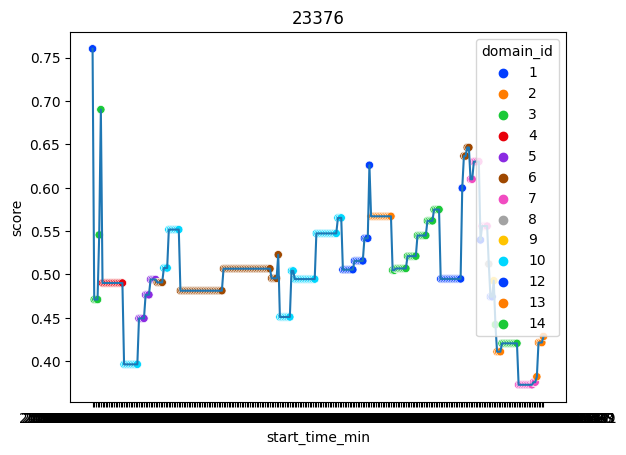

In [257]:
sns.scatterplot(data=final_df[final_df.patient_id == pid], x="start_time_min", y="score", hue="domain_id", palette="bright").set_title(pid)
plt.plot(final_df[final_df.patient_id == pid]["start_time_min"], final_df[final_df.patient_id == pid]["score"])

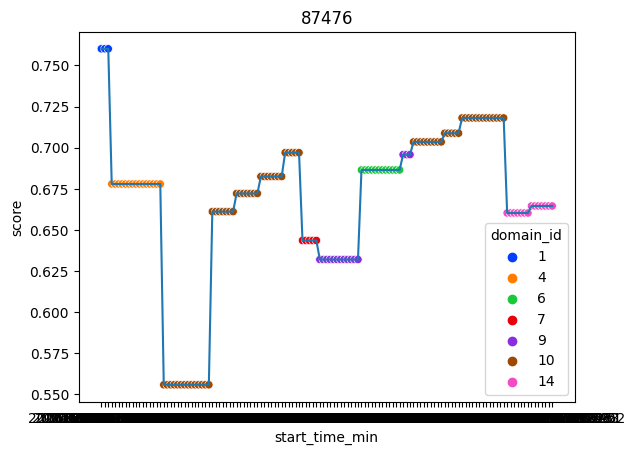

In [192]:
sns.scatterplot(data=final_df[final_df.patient_id == pid], x="start_time_min", y="score", hue="domain_id", palette="bright").set_title(pid)
plt.plot(final_df[final_df.patient_id == pid]["start_time_min"], final_df[final_df.patient_id == pid]["score"])

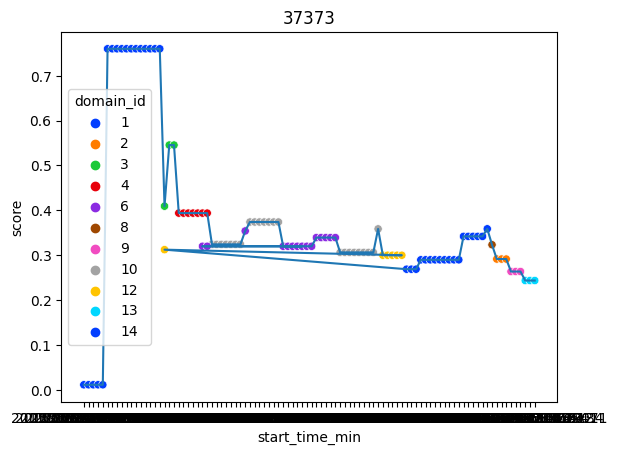

In [188]:
sns.scatterplot(data=final_df[final_df.patient_id == 37373], x="start_time_min", y="score", hue="domain_id", palette="bright").set_title(37373)
plt.plot(final_df[final_df.patient_id == 37373]["start_time_min"], final_df[final_df.patient_id == 37373]["score"])

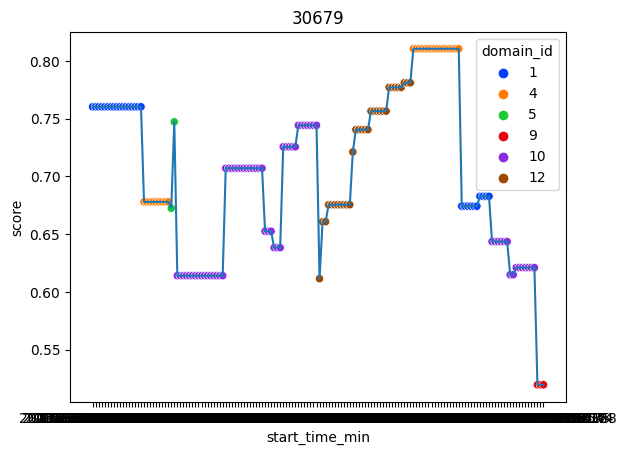

In [186]:
sns.scatterplot(data=final_df[final_df.patient_id == 30679], x="start_time_min", y="score", hue="domain_id", palette="bright").set_title(30679)
plt.plot(final_df[final_df.patient_id == 30679]["start_time_min"], final_df[final_df.patient_id == 30679]["score"])

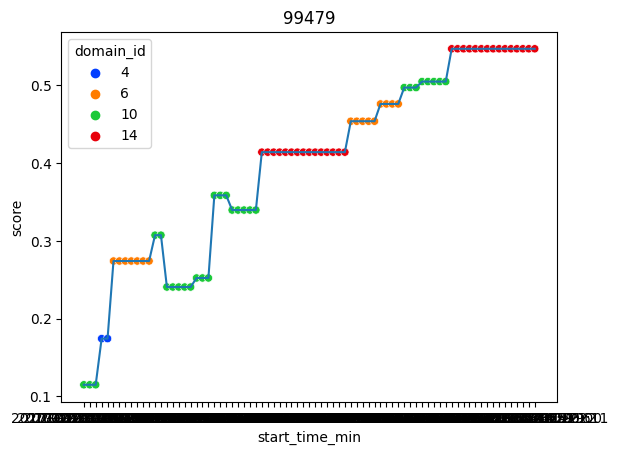

In [185]:
sns.scatterplot(data=final_df[final_df.patient_id == 99479], x="start_time_min", y="score", hue="domain_id", palette="bright").set_title(99479)
plt.plot(final_df[final_df.patient_id == 99479]["start_time_min"], final_df[final_df.patient_id == 99479]["score"])

Second metric calculation:
* keep other domains constant 
* how do we start off each domain -> average of when people first start out or just average

In [195]:
df_pct

,id,patient_id,task_type_id,task_level,completed_task_count,accuracy,condition_since,birth_year,start_time,start_time_min,end_time_min,deficit_id,disorder_id,domain_id,progression_order,percentile
0,639141,15796,20,1,2,0.032,5y,1950,2014-08-02,2014-08-02 21:11:37,2014-08-02 21:11:40,"{1, 2, 3, 4, 8}","{2, 3}",1,0,0.010932
1,659924,16441,20,1,3,1.000,6m,1959,2014-08-08,2014-08-08 16:21:14,2014-08-08 16:21:54,"{1, 2, 3, 4}",{2},1,0,0.010932
2,677465,16441,20,1,3,1.000,6m,1959,2014-08-13,2014-08-13 01:07:54,2014-08-13 01:08:17,"{1, 2, 3, 4}",{2},1,0,0.010932
3,677586,16441,20,1,3,1.000,6m,1959,2014-08-13,2014-08-13 01:36:48,2014-08-13 01:37:13,"{1, 2, 3, 4}",{2},1,0,0.010932
4,679091,16441,20,1,3,1.000,6m,1959,2014-08-13,2014-08-13 16:15:30,2014-08-14 02:40:50,"{1, 2, 3, 4}",{2},1,0,0.010932
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1596598,4662260,82474,75,1,10,0.780,1y,1983,2016-09-20,2016-09-20 18:52:46,2016-09-20 18:57:20,"{1, 2, 3, 4}","{2, 3}",8,3,0.327813
1596599,4682259,82474,75,1,10,0.870,1y,1983,2016-09-22,2016-09-22 17:29:06,2016-09-22 17:33:08,"{1, 2, 3, 4}","{2, 3}",8,3,0.327813
1596600,4698670,82474,75,1,10,0.900,1y,1983,2016-09-24,2016-09-24 15:58:14,2016-09-24 16:03:42,"{1, 2, 3, 4}","{2, 3}",8,3,0.327813
1596601,4704074,82474,75,1,10,0.900,1y,1983,2016-09-25,2016-09-25 14:45:49,2016-09-25 14:53:32,"{1, 2, 3, 4}","{2, 3}",8,3,0.327813


First: average across all sessions

In [197]:
df_pct.groupby("domain_id")["percentile"].mean()

domain_id
1     0.500004
2     0.500007
3     0.500004
4     0.500005
5     0.500006
6     0.500004
7     0.500008
8     0.500051
9     0.500004
10    0.500002
12    0.500002
13    0.500012
14    0.500004
Name: percentile, dtype: float64

In [231]:
# take in individual dataframe and output dataframe with overall performance metric
def get_score_avg(data):
    # initialize score with average
    score = [0.5 for i in range(14)]
    scores = []
    

    data.sort_values(by="end_time_min") # sort data by time

    for idx, row in data.iterrows():
        score[row["domain_id"] - 1] = row["percentile"]
        # set score to the score list average
        scores.append(sum(score) / len(score))
    data["score"] = scores
    return data

In [232]:
## get performance metric by each patient for each session
avg_final_df = df_pct.groupby("patient_id").apply(get_score_avg).reset_index(drop=True)
avg_final_df

/var/folders/vv/6vndbrvd7r1gc7xq3qqx8tfh0000gq/T/ipykernel_65590/826046786.py:2: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  avg_final_df = df_pct.groupby("patient_id").apply(get_score_avg).reset_index(drop=True)


,id,patient_id,task_type_id,task_level,completed_task_count,accuracy,condition_since,birth_year,start_time,start_time_min,end_time_min,deficit_id,disorder_id,domain_id,progression_order,percentile,score
0,639141,15796,20,1,2,0.032,5y,1950,2014-08-02,2014-08-02 21:11:37,2014-08-02 21:11:40,"{1, 2, 3, 4, 8}","{2, 3}",1,0,0.010932,0.465067
1,659924,16441,20,1,3,1.000,6m,1959,2014-08-08,2014-08-08 16:21:14,2014-08-08 16:21:54,"{1, 2, 3, 4}",{2},1,0,0.010932,0.465067
2,677465,16441,20,1,3,1.000,6m,1959,2014-08-13,2014-08-13 01:07:54,2014-08-13 01:08:17,"{1, 2, 3, 4}",{2},1,0,0.010932,0.465067
3,677586,16441,20,1,3,1.000,6m,1959,2014-08-13,2014-08-13 01:36:48,2014-08-13 01:37:13,"{1, 2, 3, 4}",{2},1,0,0.010932,0.465067
4,679091,16441,20,1,3,1.000,6m,1959,2014-08-13,2014-08-13 16:15:30,2014-08-14 02:40:50,"{1, 2, 3, 4}",{2},1,0,0.010932,0.465067
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1596598,4662260,82474,75,1,10,0.780,1y,1983,2016-09-20,2016-09-20 18:52:46,2016-09-20 18:57:20,"{1, 2, 3, 4}","{2, 3}",8,3,0.327813,0.524125
1596599,4682259,82474,75,1,10,0.870,1y,1983,2016-09-22,2016-09-22 17:29:06,2016-09-22 17:33:08,"{1, 2, 3, 4}","{2, 3}",8,3,0.327813,0.524125
1596600,4698670,82474,75,1,10,0.900,1y,1983,2016-09-24,2016-09-24 15:58:14,2016-09-24 16:03:42,"{1, 2, 3, 4}","{2, 3}",8,3,0.327813,0.524125
1596601,4704074,82474,75,1,10,0.900,1y,1983,2016-09-25,2016-09-25 14:45:49,2016-09-25 14:53:32,"{1, 2, 3, 4}","{2, 3}",8,3,0.327813,0.524125


Let's look at results

30267


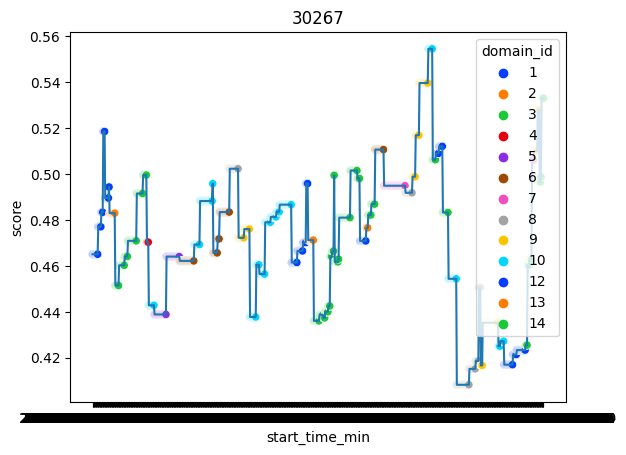

In [213]:
import random
pid = random.choice(pd.unique(avg_final_df["patient_id"]))
print(pid)
sns.scatterplot(data=avg_final_df[avg_final_df.patient_id == pid], x="start_time_min", y="score", hue="domain_id", palette="bright").set_title(pid)
plt.plot(avg_final_df[avg_final_df.patient_id == pid]["start_time_min"], avg_final_df[avg_final_df.patient_id == pid]["score"])

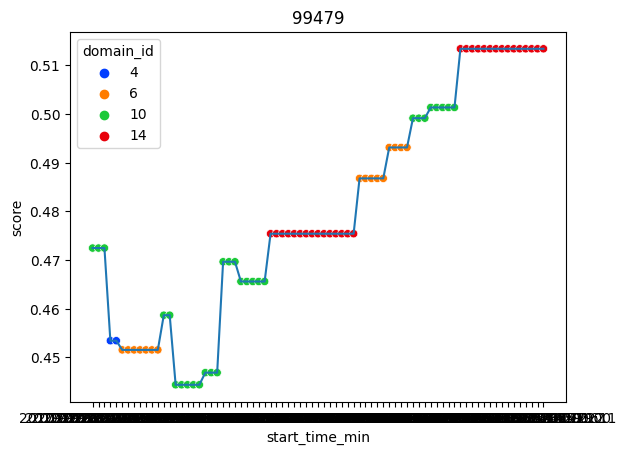

In [214]:
sns.scatterplot(data=avg_final_df[avg_final_df.patient_id == 99479], x="start_time_min", y="score", hue="domain_id", palette="bright").set_title(99479)
plt.plot(avg_final_df[avg_final_df.patient_id == 99479]["start_time_min"], avg_final_df[avg_final_df.patient_id == 99479]["score"])

Second average method: average starting point

In [215]:
df_pct

,id,patient_id,task_type_id,task_level,completed_task_count,accuracy,condition_since,birth_year,start_time,start_time_min,end_time_min,deficit_id,disorder_id,domain_id,progression_order,percentile
0,639141,15796,20,1,2,0.032,5y,1950,2014-08-02,2014-08-02 21:11:37,2014-08-02 21:11:40,"{1, 2, 3, 4, 8}","{2, 3}",1,0,0.010932
1,659924,16441,20,1,3,1.000,6m,1959,2014-08-08,2014-08-08 16:21:14,2014-08-08 16:21:54,"{1, 2, 3, 4}",{2},1,0,0.010932
2,677465,16441,20,1,3,1.000,6m,1959,2014-08-13,2014-08-13 01:07:54,2014-08-13 01:08:17,"{1, 2, 3, 4}",{2},1,0,0.010932
3,677586,16441,20,1,3,1.000,6m,1959,2014-08-13,2014-08-13 01:36:48,2014-08-13 01:37:13,"{1, 2, 3, 4}",{2},1,0,0.010932
4,679091,16441,20,1,3,1.000,6m,1959,2014-08-13,2014-08-13 16:15:30,2014-08-14 02:40:50,"{1, 2, 3, 4}",{2},1,0,0.010932
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1596598,4662260,82474,75,1,10,0.780,1y,1983,2016-09-20,2016-09-20 18:52:46,2016-09-20 18:57:20,"{1, 2, 3, 4}","{2, 3}",8,3,0.327813
1596599,4682259,82474,75,1,10,0.870,1y,1983,2016-09-22,2016-09-22 17:29:06,2016-09-22 17:33:08,"{1, 2, 3, 4}","{2, 3}",8,3,0.327813
1596600,4698670,82474,75,1,10,0.900,1y,1983,2016-09-24,2016-09-24 15:58:14,2016-09-24 16:03:42,"{1, 2, 3, 4}","{2, 3}",8,3,0.327813
1596601,4704074,82474,75,1,10,0.900,1y,1983,2016-09-25,2016-09-25 14:45:49,2016-09-25 14:53:32,"{1, 2, 3, 4}","{2, 3}",8,3,0.327813


In [236]:
domain_avg = df_pct.sort_values(by="end_time_min")
domain_avg = domain_avg.drop_duplicates(subset=["patient_id", "domain_id"])

13

In [258]:
lst = list(domain_avg.groupby("domain_id")["percentile"].mean().reset_index()["percentile"])
lst

[0.6100743781540587,
 0.24204539402210767,
 0.4891959776910087,
 0.35780930034985403,
 0.3993197387853732,
 0.4156942776756867,
 0.2939467616399571,
 0.26132977104920374,
 0.41186862673627106,
 0.3534001675966456,
 0.23161465712048854,
 0.42848962051203715,
 0.4432483770191272]

In [241]:
# take in individual dataframe and output dataframe with overall performance metric
def get_score_avg2(data):
    # initialize score with average
    score = [0.6100743781540587,
 0.24204539402210767,
 0.4891959776910087,
 0.35780930034985403,
 0.3993197387853732,
 0.4156942776756867,
 0.2939467616399571,
 0.26132977104920374,
 0.41186862673627106,
 0.3534001675966456,
0.3798490037193707,
 0.23161465712048854,
 0.42848962051203715,
 0.4432483770191272]
    scores = []
    
    data.sort_values(by="end_time_min") # sort data by time

    for idx, row in data.iterrows():
        score[row["domain_id"] - 1] = row["percentile"]
        # set score to the score list average
        scores.append(sum(score) / len(score))
    data["score"] = scores
    return data

In [242]:
## get performance metric by each patient for each session
avg_final_df2 = df_pct.groupby("patient_id").apply(get_score_avg2).reset_index(drop=True)
avg_final_df2

/var/folders/vv/6vndbrvd7r1gc7xq3qqx8tfh0000gq/T/ipykernel_65590/3752956984.py:2: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  avg_final_df2 = df_pct.groupby("patient_id").apply(get_score_avg2).reset_index(drop=True)


,id,patient_id,task_type_id,task_level,completed_task_count,accuracy,condition_since,birth_year,start_time,start_time_min,end_time_min,deficit_id,disorder_id,domain_id,progression_order,percentile,score
0,639141,15796,20,1,2,0.032,5y,1950,2014-08-02,2014-08-02 21:11:37,2014-08-02 21:11:40,"{1, 2, 3, 4, 8}","{2, 3}",1,0,0.010932,0.337053
1,659924,16441,20,1,3,1.000,6m,1959,2014-08-08,2014-08-08 16:21:14,2014-08-08 16:21:54,"{1, 2, 3, 4}",{2},1,0,0.010932,0.337053
2,677465,16441,20,1,3,1.000,6m,1959,2014-08-13,2014-08-13 01:07:54,2014-08-13 01:08:17,"{1, 2, 3, 4}",{2},1,0,0.010932,0.337053
3,677586,16441,20,1,3,1.000,6m,1959,2014-08-13,2014-08-13 01:36:48,2014-08-13 01:37:13,"{1, 2, 3, 4}",{2},1,0,0.010932,0.337053
4,679091,16441,20,1,3,1.000,6m,1959,2014-08-13,2014-08-13 16:15:30,2014-08-14 02:40:50,"{1, 2, 3, 4}",{2},1,0,0.010932,0.337053
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1596598,4662260,82474,75,1,10,0.780,1y,1983,2016-09-20,2016-09-20 18:52:46,2016-09-20 18:57:20,"{1, 2, 3, 4}","{2, 3}",8,3,0.327813,0.464873
1596599,4682259,82474,75,1,10,0.870,1y,1983,2016-09-22,2016-09-22 17:29:06,2016-09-22 17:33:08,"{1, 2, 3, 4}","{2, 3}",8,3,0.327813,0.464873
1596600,4698670,82474,75,1,10,0.900,1y,1983,2016-09-24,2016-09-24 15:58:14,2016-09-24 16:03:42,"{1, 2, 3, 4}","{2, 3}",8,3,0.327813,0.464873
1596601,4704074,82474,75,1,10,0.900,1y,1983,2016-09-25,2016-09-25 14:45:49,2016-09-25 14:53:32,"{1, 2, 3, 4}","{2, 3}",8,3,0.327813,0.464873


102674


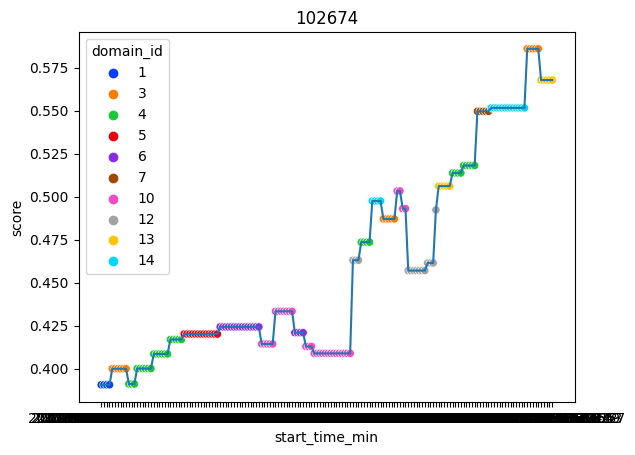

In [255]:
import random
pid = random.choice(pd.unique(avg_final_df2["patient_id"]))
print(pid)
sns.scatterplot(data=avg_final_df2[avg_final_df2.patient_id == pid], x="start_time_min", y="score", hue="domain_id", palette="bright").set_title(pid)
plt.plot(avg_final_df2[avg_final_df2.patient_id == pid]["start_time_min"], avg_final_df2[avg_final_df2.patient_id == pid]["score"])

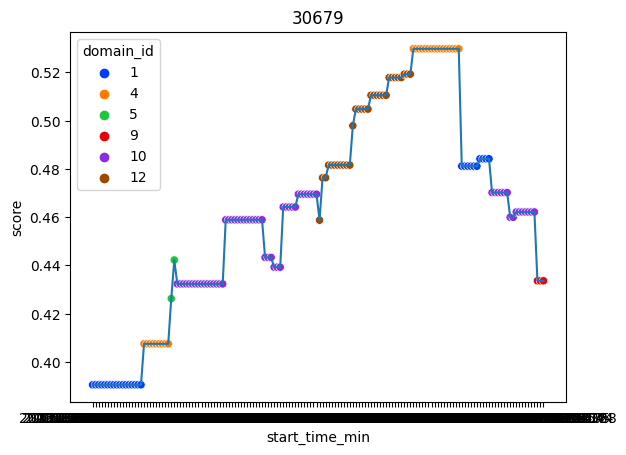

In [246]:
sns.scatterplot(data=avg_final_df2[avg_final_df2.patient_id == 30679], x="start_time_min", y="score", hue="domain_id", palette="bright").set_title(30679)
plt.plot(avg_final_df2[avg_final_df2.patient_id == 30679]["start_time_min"], avg_final_df2[avg_final_df2.patient_id == 30679]["score"])